# Predykcja ataku <font color="DarkRed"><b>phishingowego</b></font> w wiadomości e-mail za pomocą <font color="orange"><b><i>nadzorowanego nauczania maszynowego</i></b>o</font>
Dataset: 
<ul>
    <li><i><b>Phishing Email Curated Datasets</b></i></li>
    <ul>
        <li><a href="https://zenodo.org/records/8339691" target="_blank" style="color: orange">https://zenodo.org/records/8339691</a></li>
    </ul>
</ul>

### Najważniejsze użyte <font color="orange">moduły</font>
<ul>
    <li> <b>pandas</b> - praca z <i>Data Framami</i></li>
    <li> <b>numpy</b> - obliczenia</li>
    <li> <b>matplotlib.pyplot</b> - wizualizacja</li>
    <li> <b>sklearn</b> - wszelakie narzędzia do <i>Machine Learningu</i></li>
</ul>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as skm

from unidecode import unidecode
from termcolor import colored
import import_ipynb
import os
import re

cores = os.cpu_count()
cpu_usage = 'medium'

if cpu_usage == 'high':
    cores_used = -1
elif cpu_usage == 'medium':
    cores_used = cores // 2
else:
    cores_used = 1


print('CPU Cores: ', cores)
print('Used CPU Cores: ', cores_used)

CPU Cores:  12
Used CPU Cores:  6


### Tworzymy <font color="orange">metodę</font> do <font color="orange">konwertowania maila</font> na <font color="orange">wartości liczbowe</font> na wzór tych użytych przy nauczaniu modelu

In [2]:
safe_mail = {
'sender': 'Hanna.Wdowicka@ue.poznan.pl',
'subject': 'Reaktywacja SKN',
'body': '''
        Szanowni Państwo,

        Poniżej przekazuję wiadomość od dr Macieja Beęsewicza, prof. UEP. Osoby zainteresowane zachęcam do kontaktu!
        Pozdrawiam,
        Hanna Wdowicka

        Temat: Reaktywacja SKN Estymator

        Treść:

        Szanowni Państwo,

        dr Maciej Beręsewicz z Katedry Statystyki poszukuje studentów/tek zainteresowanych statystyką oraz matematyką, którzy lubią wyznaczać pochodne i całki, do pracy naukowej w ramach działalności koła naukowego Estymator. W szczególności poszukuje osób, których interesuje tematyka rynku pracy, statystyka, programowanie w języku R, posiadających zacięcie matematyczne oraz czas wolny do projektów związanych z analizą ofert pracy oraz szacowania wielkości populacji.

        Poniżej przedstawiono przykłady prac, które będą realizowane w ramach pracy w kole:

        1. Estimating the number of entities with vacancies using administrative and online data -- https://arxiv.org/abs/2106.03263
        2. Inferring job vacancies from online job advertisements -- https://ec.europa.eu/eurostat/web/products-statistical-working-papers/-/ks-tc-20-008
        3. Enhancing the Demand for Labour survey by including skills from online job advertisements using model-assisted calibration -- https://ojs.ub.uni-konstanz.de/srm/article/view/7670
        4. Maximum entropy classification for record linkage — https://htmlpreview.github.io/?https://github.com/ncn-foreigners/mecRecordLinkage/blob/main/mecRecordLinkage.html
        5. Developing methods for determining the number of unauthorized foreigners in Norway — https://www.ssb.no/a/english/publikasjoner/pdf/doc_200811_en/doc_200811_en.pdf

        Proszę się kontaktować przez mail maciej.beresewicz@ue.poznan.pl lub przez MS Teams.

        Z poważaniem

        dr Maciej Beręsewicz, prof. UEP

        Katedra Statystyki
        Uniwersytet Ekonomiczny w Poznaniu
        Department of Statistics
        Poznań University of Economics and Business
        al. Niepodległości 10 | 61-875 Poznań
        tel. + 48 61-854-36-80 | maciej.beresewicz@ue.poznan.pl
        www.ue.poznan.pl
'''
}

In [3]:
phishing_mail = {
'sender': 'x3r0@ysadna321.com',
'subject': 'Your xero invoice available now.',
'body': '''
        Hi,
        Thanks for working with us. Your bill for $373.75 was due on 28 Aug 2016.
        If you've already paid it, please ignore this email and sorry for bothering you. If you've not paid it, please do so as soon as possible.
        To view your bill visit http://in.x312412.qweds12/5LQDhRwfvoQfeDtLDMqkk1JWSqC4CmJt4VVJRSGN.
        If you've got any questions, or want to arrange alternative payment don't hesitate to get in touch.
        Thanks
        NJW Limited
        Download PDF
'''
}

In [4]:
from unidecode import unidecode
import spacy
import re

nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])
def import_suspicious_words():
    with open('suspicious_words.txt', 'r') as file:
        lines = file.readlines()
    
    suspicious_words = []
    for line in lines:
        word = line.strip()
        suspicious_words.append(word)

    suspicious_str = ' '.join(suspicious_words)
    doc = nlp(suspicious_str)
    suspicious_lemmas = [token.lemma_.lower() for token in doc]

    suspicious_set = set(suspicious_lemmas)
    return suspicious_set
def parse_mail_to_nums(mail: dict):
    
    sender = mail['sender']
    splitted = sender.split('@')
    
    sender_name = splitted[0]
    sender_domain = splitted[1]
    
    sender_num_count = sum(1 for char in sender_name if char.isnumeric())

    splitted_dom = sender_domain.split('.')[:-1]
    domain_noTLD = '.'.join(splitted_dom)
    print(domain_noTLD)
    sender_domain_num_count = sum(1 for char in domain_noTLD if char.isnumeric())
    print('sender_domain_num_count ', sender_domain_num_count)
    sender_domain_length = len(domain_noTLD)
    
    # subject and body text
    suspicious_set = import_suspicious_words()

    doc = nlp(mail['subject'])
    tokens = [token.lemma_.lower() for token in doc if token.text.isalnum()]
    unique_words = set(tokens)
    sus_words = unique_words.intersection(suspicious_set)
    suspicious_words_subject = len(sus_words)

    doc = nlp(mail['body'])
    tokens = [token.lemma_.lower() for token in doc if token.text.isalnum()]
    unique_words = set(tokens)
    sus_words = unique_words.intersection(suspicious_set)
    suspicious_words_body = len(sus_words)


    # body urls
    body = mail['body']
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    urls = re.findall(url_pattern, body)
    # urls_count
    urls_count = len(urls)
    url = urls[np.random.randint(0, urls_count)]
    # protocol
    protocol = url[:5].lower()
    protocol = 'https' if protocol == 'https' else 'http'
    # contains_ip
    IP_pattern = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b|\b(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}\b')
    IPs = IP_pattern.findall(url)
    contains_ip = 1 if IPs else 0
    # url_length
    url_length = len(url)
    # TLD_alpha
    pattern = re.compile(r'https?://([^/?]+)')
    match = pattern.match(url)
    if match:
        domain = match.group(1)
        if '/' in domain:
            domain = domain.split('/')[0]
    else:
        domain = url
    
    split_domain = domain.split('.')
    n = len(split_domain)
    delimiters = ['/', ':', ')', ']', '%', '_', '=', ',', '>', '"', '#', '!']
    # Check if not weird ending
    after_dot = split_domain[n-1]
    if len(after_dot) > 2 and not after_dot.isalpha():
        after_dot = after_dot.split('/')[0]
        
        if len(after_dot) > 2 and not after_dot.isalpha():
            print(after_dot, 'INSIDE')
            for delimiter in delimiters:
                after_dot = " ".join(after_dot.split(delimiter))
            
            after_dot = after_dot.split()[0]

    TLD = '.'+after_dot.lower()
    TLD_alpha = TLD[1:].isalpha()
    # subdomain_level
    subdomain_level = domain.count('.')-1
    # slash_count
    slash_count = url.count('/')
    # dots_count
    dots_count = url.count('.')
    # hyphens_count
    hyphens_count = url.count('-')
    # has_non_latin
    ascii = unidecode(url)
    has_non_latin = url != ascii

    data = {
        'sender_num_count': sender_num_count,
        'sender_domain_num_count': sender_domain_num_count,
        'sender_domain_length': sender_domain_length,
        'suspicious_words_subject': suspicious_words_subject,
        'suspicious_words_body': suspicious_words_body,
        'urls_count': urls_count,
        'protocol': protocol,
        'contains_ip': contains_ip,
        'url_length': url_length,
        'TLD_alpha': TLD_alpha,
        'subdomain_level': subdomain_level,
        'slash_count': slash_count,
        'dots_count': dots_count,
        'hyphens_count': hyphens_count,
        'has_non_latin': has_non_latin,
    }

    for k, v in data.items():
        print('{}: {}'.format(k, v), end='\n')

    # numeric values
    urls_count_out = urls_count if urls_count <= 2 else 3
    protocol_out = 1 if protocol=='https' else 0
    contains_ip_out = contains_ip
    url_length_out = url_length
    TLD_alpha_out = 1 if TLD_alpha is True else 0
    subdomain_level_out = subdomain_level if subdomain_level <= 2 else 3
    slash_count_out = slash_count if slash_count <= 5 else 6
    dots_count_out = dots_count if dots_count <= 4 else 5
    hyphens_count_out = hyphens_count if hyphens_count <= 1 else 2
    has_non_latin_out = has_non_latin

    X_output = np.array(list([
        [sender_num_count],
        [sender_domain_num_count],
        [sender_domain_length],
        [suspicious_words_subject],
        [suspicious_words_body],
        [urls_count_out],
        [protocol_out],
        [contains_ip_out],
        [url_length_out],
        [TLD_alpha_out],
        [subdomain_level_out],
        [slash_count_out],
        [dots_count_out],
        [hyphens_count_out],
        [has_non_latin_out]
    ]))
    return X_output.reshape(1, -1)

### Wczytanie przygotowanego <font color="orange"><b>data framu</b></font>

In [5]:
learning_set = pd.read_csv('ML_DataFrame.csv', index_col=0)
learning_set

,is_phishing,is_safe,suspicious_words_subject,suspicious_words_body,sender_nums_count,sender_domain_num_count,sender_domain_length,urls_count,protocol,contains_ip,url_length,TLD_alpha,subdomain_level,slash_count,dots_count,hyphens_count,has_non_latin
0,1.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,0.0,0.0,21.0,1.0,0.0,3.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,4.0,0.0,6.0,1.0,0.0,0.0,25.0,1.0,1.0,2.0,2.0,0.0,0.0
2,1.0,0.0,0.0,4.0,0.0,0.0,16.0,3.0,0.0,0.0,107.0,1.0,1.0,6.0,5.0,0.0,0.0
3,0.0,1.0,0.0,2.0,0.0,0.0,5.0,3.0,0.0,0.0,18.0,0.0,0.0,2.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,15.0,1.0,0.0,0.0,136.0,1.0,2.0,4.0,4.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99454,1.0,0.0,1.0,9.0,0.0,0.0,6.0,1.0,1.0,0.0,35.0,1.0,1.0,4.0,3.0,0.0,0.0
99455,1.0,0.0,0.0,0.0,3.0,0.0,7.0,1.0,0.0,0.0,22.0,1.0,2.0,0.0,3.0,0.0,0.0
99460,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,17.0,1.0,1.0,0.0,2.0,0.0,0.0
99466,1.0,0.0,0.0,1.0,3.0,3.0,3.0,1.0,0.0,0.0,21.0,1.0,1.0,0.0,2.0,0.0,0.0


In [6]:
print(learning_set[learning_set['is_phishing']==1.0].shape)
print(learning_set[learning_set['is_phishing']==0.0].shape)

(25614, 17)
(16044, 17)


### Usunięcie <font color="orange"><b>wierszy</b></font> z <font color="orange">pustym wartościami</font>

In [7]:
learning_set.isna().sum()
learning_set.dropna(inplace=True)

### Wybranie <font color="orange"><b><i>X</i></b></font> i <font color="orange"><b><i>y</i></b></font>
X:
<ul>
    <li> suspicious_words_subject </li>
    <li> suspicious_words_body </li>
    <li> sender_nums_count </li>
    <li> sender_domain_num_count </li>
    <li> sender_domain_length </li>
    <li> urls_count </li>
    <li> protocol </li>
    <li> contains_ip </li>
    <li> url_length </li>
    <li> TLD_alpha </li>
    <li> subdomain_level </li>
    <li> slash_count </li>
    <li> dots_count </li>
    <li> hyphens_count </li>
    <li> has_non_latin </li>
</ul>
y:
<ul>
    <li> is_phishing </li>
    <li> is_safe </li>
</ul>

In [8]:
X_train = learning_set.loc[:, 'suspicious_words_subject':'has_non_latin'].values
y_train = learning_set.loc[: , ['is_safe']].values.ravel()
print(X_train.shape, y_train.shape)

(41574, 15) (41574,)


### <font color="orange">Skalujemy</font> wartości <font color="orange"><b><i>X</i></b>-ów</font>

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

safe_mail = scaler.fit_transform(parse_mail_to_nums(safe_mail))
phishing_mail = scaler.fit_transform(parse_mail_to_nums(phishing_mail))

ue.poznan
sender_domain_num_count  0
sender_num_count: 0
sender_domain_num_count: 0
sender_domain_length: 9
suspicious_words_subject: 0
suspicious_words_body: 2
urls_count: 6
protocol: http
contains_ip: 0
url_length: 16
TLD_alpha: True
subdomain_level: 2
slash_count: 0
dots_count: 3
hyphens_count: 0
has_non_latin: False
ysadna321
sender_domain_num_count  3
qweds12 INSIDE
sender_num_count: 2
sender_domain_num_count: 3
sender_domain_length: 9
suspicious_words_subject: 1
suspicious_words_body: 2
urls_count: 1
protocol: http
contains_ip: 0
url_length: 67
TLD_alpha: False
subdomain_level: 1
slash_count: 3
dots_count: 3
hyphens_count: 0
has_non_latin: False


### Szukanie <font color="orange">najlepszego modelu</font>


### Tworzymy dict modeli i hiperparametrów, który chcemy sprawdzić.

In [10]:
models = {
    'DecisionTree': (DecisionTreeClassifier(), {
            'max_depth': [None, 10, 20, 30],
            'criterion': ['gini', 'entropy'],
            'min_samples_split': range(2, 31, 2),
            'min_samples_leaf': range(2, 31, 2)  
    }),
    'KNeighbors': (KNeighborsClassifier(), {
        'weights': ['uniform', 'distance'],
        'n_neighbors': range(4, 41, 2),
        'p': [1, 2],
    }),
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [10, 50, 100, 200],
        'n_estimators': [400, 700, 1000],
        'min_samples_split': range(2, 11, 4),
        'min_samples_leaf': range(2, 11, 4)
    }),
    'GradientBoosting': (GradientBoostingClassifier(), {
         'loss': ['log_loss', 'exponential'],
        'learning_rate': np.linspace(0.001, 2, 5),
        'min_samples_leaf': np.linspace(1, 50, 5, dtype=int)
    })
}

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metric_used = 'accuracy'

In [12]:
scores = []
best_models = {}
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, scoring=metric_used, cv=kf, refit=True, n_jobs=cores_used)
    grid_search.fit(X_train, y_train)

    print(f"Najlepsze hiperparametry dla {name}: {grid_search.best_params_}")

    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring=metric_used, cv=kf, n_jobs=cores_used)
    print(f"CV {metric_used} dla {name}: {cv_scores}")
    print(f"Średnie CV {metric_used}: {cv_scores.mean()}")
    scores.append(cv_scores)

    best_models[name] = grid_search.best_estimator_
    print('='*80)

KeyboardInterrupt: 

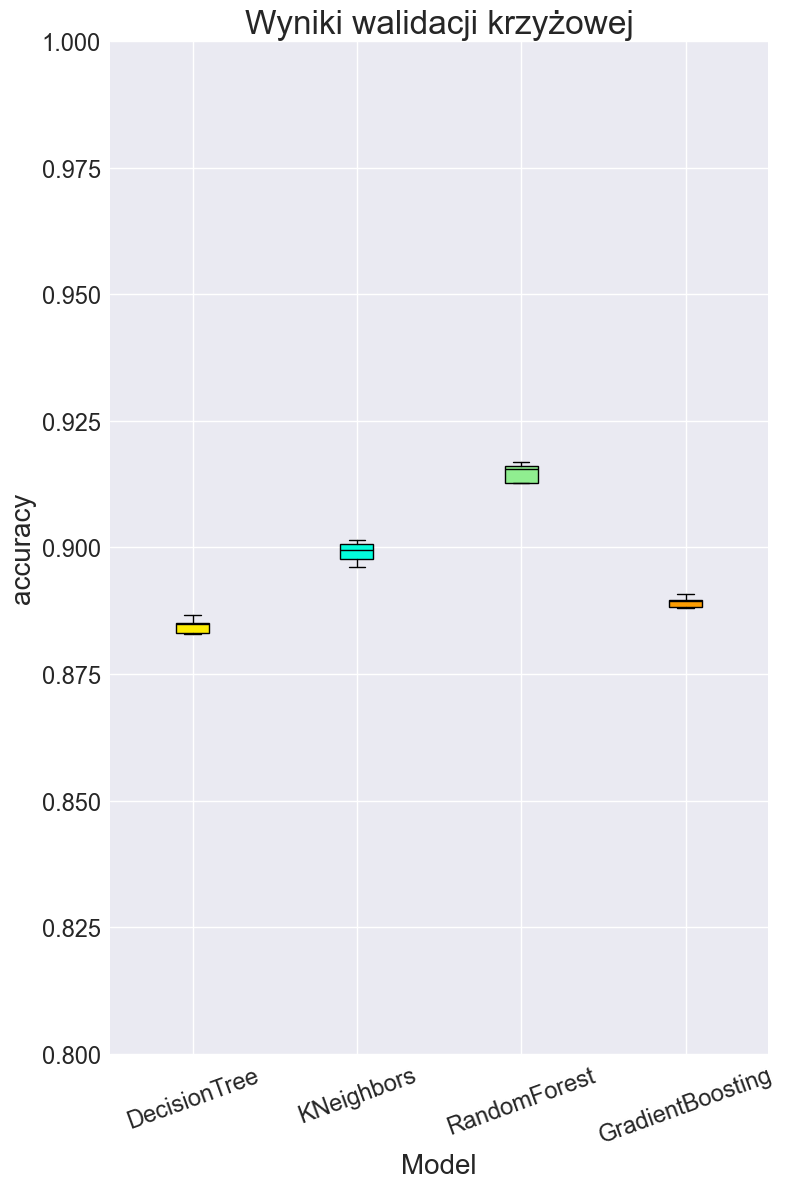

In [ ]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(8, 12))

boxplot = ax.boxplot(
    scores,
    labels=models.keys(),
    patch_artist=True,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(linewidth=1),
    capprops=dict(linewidth=1),
    medianprops=dict(color='black', linewidth=1),
    widths=0.2,
)

box_colors = ['#fceb03', '#03fcdb', '#90EE90', '#fc9d03', '#FFC0CB']
for box, color in zip(boxplot['boxes'], box_colors):
    box.set(facecolor=color)

ax.set_title('Wyniki walidacji krzyżowej', fontsize=24)
ax.tick_params(axis='both', labelsize=17)
ax.set_xlabel('Model', fontsize=20)
ax.set_ylabel(metric_used, fontsize=20)
ax.set_ylim(0.80, 1)
ax.yaxis.grid(True)
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

In [ ]:
classes = {
    0: 'safe',
    1: 'phishing'
}
colors = {
    0: 'green',
    1: 'red'
}
for name, estimator in best_models.items():
    
    print(name)
    print('-'*40)
    safe_prediction = estimator.predict(safe_mail)[0]
    safe_proba = estimator.predict_proba(safe_mail)[:][0]
    phishing_prediction = estimator.predict(phishing_mail)[0]
    phishing_proba = estimator.predict_proba(phishing_mail)[:][0]
    print(safe_proba)
    print('Bezpieczny mail przewidziany jako:')
    print(colored(f'{classes[safe_prediction]} [{np.round(safe_proba[int(safe_prediction)], 3)}]', colors[safe_prediction]))
    print('Phishingowy mail przewidziany jako:', end='\n')
    print(colored(f'{classes[phishing_prediction]} [{np.round(phishing_proba[int(phishing_prediction)], 3)}]', colors[phishing_prediction]))
    print('='*40, '\n')

DecisionTree
----------------------------------------
[0.45454545 0.54545455]
Bezpieczny mail przewidziany jako:
phishing [0.545]
Phishingowy mail przewidziany jako:
phishing [0.545]

KNeighbors
----------------------------------------
[0.83489509 0.16510491]
Bezpieczny mail przewidziany jako:
safe [0.835]
Phishingowy mail przewidziany jako:
safe [0.835]

RandomForest
----------------------------------------
[0.68349314 0.31650686]
Bezpieczny mail przewidziany jako:
safe [0.683]
Phishingowy mail przewidziany jako:
safe [0.683]

GradientBoosting
----------------------------------------
[0.69276866 0.30723134]
Bezpieczny mail przewidziany jako:
safe [0.693]
Phishingowy mail przewidziany jako:
safe [0.693]



# ✨ <font color="orange"><b><i>Rezultat projektu</i></b></font> ✨
<hr width="45%" align="left"/>
Przy pomocy <font color="orange"><i><b>RandomForestClassifier</i></font></b> udało się wytrenować model z wynikami:
<ul>
    <li><font color="orange"><b>accuracy</b></font>: 0.91</li>
    <li><font color="orange"><b>precision</b></font>:</li>
    <ul>
        <li>safe: 0.87</li>
        <li>phishing: 0.94</li>
    </ul>  
    <li><font color="orange"><b>recall</b></font>:</li>
    <ul>
        <li>safe: 0.90</li>
        <li>phishing: 0.92</li>
    </ul>  
    <li><font color="orange"><b>f1</b></font>:</li>
    <ul>
        <li>safe: 0.89</li>
        <li>phishing: 0.93</li>
    </ul>  
</ul>
</br>
Problemy projektu
<ul>
    <li> <font color="orange">mało <b>uniwersalny</b></font> </li>
    <li> <font color="orange"><b>model</b></font> za bardzo <font color="orange">opiera się</font> na <font color="orange">odnośnikach</font> znajdujących się w e-mailu </li>
    <ul>
        <li>
            bardzo dużo maili <font color="red"><b>phishingowych</b></font>zawiera <font color="orange">buttony</font>, nie <font color="orange">klasyczne odnośniki</font>
        </li>
    </ul>

<li> <font color="orange">dostęp</font> do jakiegokolwiek sensownego <font color="orange">API</font> jest <font color="orange">płatny</font></li>
<ul>
    <li> brak sprawdzania <font color="orange">domen w blacklistach</font></li>
    <li> brak sprawdzania adresów <font color="orange">e-mail w blacklistach</font></li>
    <li> słabe/brak informacji o <font color="orange">szyfrowaniu SSL</font> </li>
    <li> brak sprawdzania <font color="orange">wieku</font> domeny </li>
</ul>
<li> Dane <font color="orange">zbierane</font> w latach <font color="orange"><b>1998</b></font>-<font color="orange"><b>2022</b></font></li>
<ul>
    <li>prawdopodobnie wiele maili pochodzi z wczesnych lat 2000</li>
    <ul>
        <li>(bardzo dużo http, nawet wśród bezpiecznych domen)</li>
    </ul>
</ul>
<li> Człowiek jakkolwiek obeznany w internecie bez problemu poradziłby sobie </br>z klasyfikowaniem ataków <font color="red"><b>phishingowych</b></font> z datasetu.</li>
</ul>
<hr width="45%" align="left"/>